In [1]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
import PIL
import cv2

In [2]:
def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1))
    x_positions = np.arange(0,nx,step_x)
    x_labels = x[::step_x]
    return x_positions, x_labels

In [3]:
def imshow(img, lines=[]):
    fig = plt.figure(figsize=(12,16))
    ax = plt.axes()

    norm = Normalize(vmin=0, vmax=255, clip=True)

    im = ax.imshow(img,interpolation='none',aspect='auto',norm=norm)

    x_values = np.linspace(0, img.shape[1], num=100)
    for intercept, slope in lines:
        ls_y_values = intercept + slope * x_values
        ax.plot(x_values, np.clip(ls_y_values, 0, img.shape[0]), color="red", linewidth=2)

    plt.ylabel('time')
    plt.xlabel('space [m]')

    cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    plt.show()

In [4]:
# path_out = "./data-mm/"
# path_out = "./Martyna/"
# path_out = "./Maria/"
# path_out = "./Wika/"
# path_out = "./Mateusz/"
path_out = "./Data/"
files = glob.glob(path_out + "*")
files.sort()

In [5]:
dx = 5.106500953873407
dt = 0.0016


data = []
first_filename = files[0]
for file in files:
    data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime(
    "2024-05-07 " + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S"
)
index = pd.date_range(start=time_start, periods=len(data), freq=f"{dt}s")


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)

In [6]:
def plot_lines_on_dataframe(df, lines, title="Lines Detected"):
    """
    Plots the DataFrame as an image with the detected lines overlaid.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame to visualize.
    lines (list): List of lines detected by HoughLinesP.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 8))
    
    # Normalize the DataFrame to [0, 255] for visualization
    img = df.values
    norm = Normalize(vmin=img.min(), vmax=img.max())
    
    plt.imshow(img, cmap='viridis', aspect='auto', norm=norm, interpolation='none')
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            plt.plot([x1, x2], [y1, y2], color='red', linewidth=2)
    
    plt.title(title)
    plt.axis("off")
    plt.colorbar(label='Intensity')
    plt.show()


In [7]:
def plot_dataframe_as_image(df, a=6, b=9):
    """
    Plots a DataFrame as an image with continuous coloring based on the range of values
    using normalization.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the image data with numeric values.
    """
    # Normalize the data to the range [0, 1]
    norm = Normalize(vmin=df.min().min(), vmax=df.max().max())
    
    # Create the plot
    plt.figure(figsize=(a, b))
    plt.imshow(df, cmap='viridis', aspect='auto', norm=norm,  interpolation="none")
    # plt.colorbar(label='Value')
    plt.title('DataFrame Visualization')
    plt.axis('off')  # Turn off axis labels for better image representation
    
    # Display the plot
    plt.show()

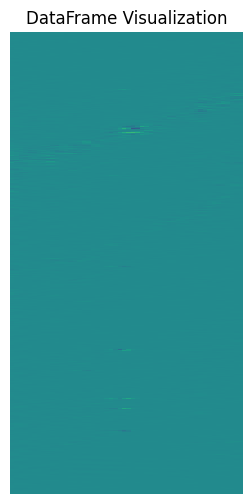

In [8]:
plot_dataframe_as_image(df.values, 3,6)

In [9]:
df = pd.DataFrame(data=data, index=index, columns=columns)
df.shape

(75000, 52)

In [10]:
#downsampling -> decreasing the spatial resolution while keeping the 2D representation of an image
#we downsample the rows
#upsampling -> increasing the spatial resolution while keeping the 2D representation of an image
#we upsample the columns
df = pd.DataFrame(data=data, index=index, columns=columns)
print(f"Shape of the df before downsampling: {df.shape}")

df = df.reindex(columns=np.arange(df.columns[0], df.columns[-1] + dx, dx / 2)).interpolate(axis=1)
print(f"Shape of the df after upsampling: {df.shape}")
df = df[::2]

print(f"Shape of the df after downsampling: {df.shape}")



df = cv2.resize(df.values, (50, 1000), interpolation=cv2.INTER_AREA)
print(f"Shape of the resized df: {df.shape}")


Shape of the df before downsampling: (75000, 52)
Shape of the df after upsampling: (75000, 104)
Shape of the df after downsampling: (37500, 104)
Shape of the resized df: (1000, 50)


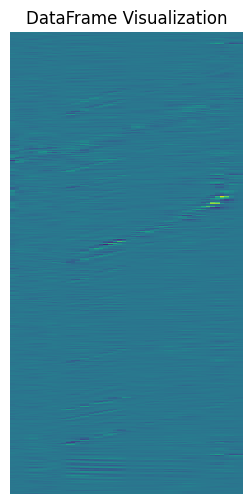

In [11]:
plot_dataframe_as_image(df,3,6)

percentile


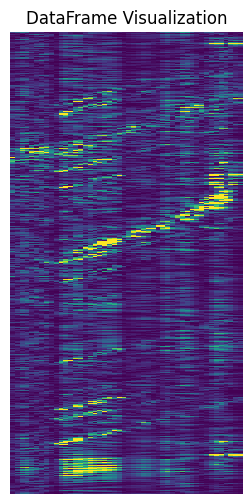

(1000, 48)


In [12]:
# df = pd.DataFrame(data=data, index=index, columns=columns)
df = pd.DataFrame(df)
df = df.iloc[:, 2:]

#ARITHMETIC OPERATIONS
# df = df.iloc[::2, :]  #cet every second row, its gonna be better for filters
# df -= df.mean()
df = np.abs(df)

#CLIP PERCENTILES FOR OUTLIERS
low, high = np.percentile(df, [3,99])
# df[:] = df.apply(lambda col: np.where(((col < low)), low, col))
# df[:] = df.apply(lambda col: np.where(((col > high)), high, col))
df.clip(low, high, inplace=True)
print("percentile")
plot_dataframe_as_image(df.values, 3,6)
print(df.shape)

normalized


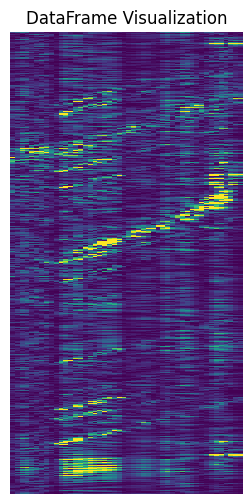

In [13]:
#NORMALIZE values to 0,255
normalized_image = cv2.normalize(df.values, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
df_normalized = pd.DataFrame(normalized_image)
print("normalized")
plot_dataframe_as_image(df_normalized,3, 6)

# #COLUMN-WISE DENOISING BASED ON MEANS IN COLUMNS AND PERCENTILES
# overall_mean = df_normalized.mean().mean()
# perc = np.percentile(df_normalized.mean(axis=1), 90)
# columns_above = df_normalized.columns[(df_normalized.mean() < perc)]
# df_normalized[columns_above] -= overall_mean*2
# print("columnwise normalization with mean-NEW")
# plot_dataframe_as_image(df_normalized.values,3, 6)

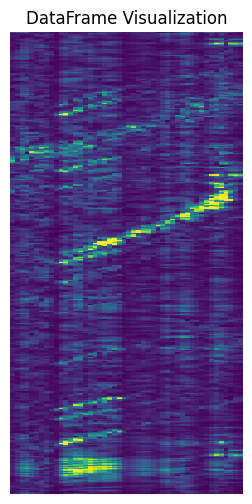

In [14]:
def column_wise_median_filter(df, kernel_size=5):
    """
    Applies a median filter to each column in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        kernel_size (int): Size of the median filter window (must be odd).
    
    Returns:
        pd.DataFrame: Denoised DataFrame.
    """
    filtered_data = df.copy()
    
    for col in df.columns:
        filtered_data[col] = cv2.medianBlur(df[col].values.astype(np.uint8), kernel_size)
    
    return filtered_data

# Apply the median filter
df_denoised = column_wise_median_filter(df_normalized, kernel_size=5)

# Visualize the result
plot_dataframe_as_image(df_denoised.values, 3, 6)

In [15]:
# # EQUALIZE
# clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
# equalized_image = clahe.apply(normalized_image)
# df_equalized = pd.DataFrame(equalized_image, columns = df.columns)
# print("equalized_image")
# plot_dataframe_as_image(df_equalized,3,6)

threshold below 20


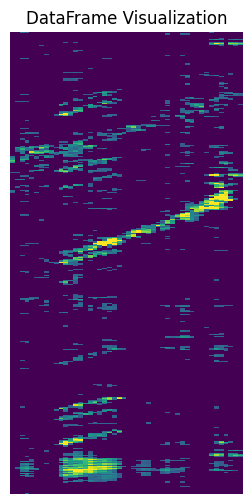

In [16]:
#BAD- INDUCES NOISE
# df_normalized = df_normalized.apply(lambda x: x - x.mean())
# print("columnwise normalization")
# plot_dataframe_as_image(df_normalized,3, 6)
df_normalized[:] = df_denoised.apply(lambda col: np.where(((col < 70)), 0, col))
print("threshold below 20")
plot_dataframe_as_image(df_normalized.values,3, 6)

Result of denoising


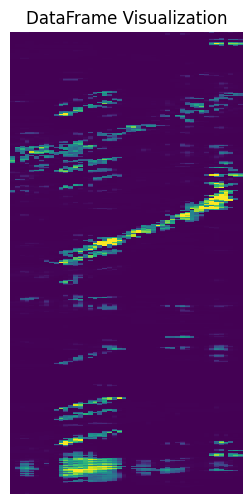

In [17]:
#NLM DENOISING
image = df_normalized.values.astype(np.uint8)
denoised_image2 = cv2.fastNlMeansDenoising(
    image,                      
    h=20,                       
    templateWindowSize=7,       
    searchWindowSize=21         
)
# df = pd.DataFrame(denoised_image, columns=df_normalized.columns)
print("Result of denoising")
# plot_dataframe_as_image(df, 3,6)
df2  = pd.DataFrame(denoised_image2, columns=df_normalized.columns)
plot_dataframe_as_image(df2.values, 3,6)

Gauss on 2nd denoise


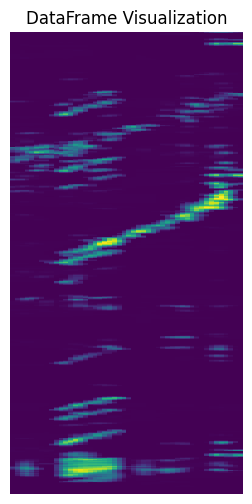

In [18]:
# #GAUSSIAN ON 3,21 KERNEL
# kernel = (3,21)
# df_gauss = pd.DataFrame(cv2.GaussianBlur(df.values.astype(np.float32), kernel, 3), columns = df.columns)
# print("Gauss")
# plot_dataframe_as_image(df_gauss,3,6)

kernel = (3,3)
df_gauss = pd.DataFrame(cv2.GaussianBlur(df2.values.astype(np.float32), kernel, 5), columns = df.columns)
print("Gauss on 2nd denoise")
plot_dataframe_as_image(df_gauss.values,3,6)

normalized background


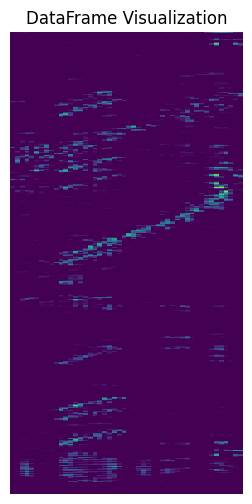

In [19]:
#THIS IS NICE. IT REMOVES GAUSSIAN-BACKGROUND BLUR, AND THEN IT APPLIES MORE CONTRAST
background = cv2.GaussianBlur(df_gauss.values.astype(np.uint8), (3,3), 0)
normalized_image = cv2.subtract(df_gauss.values.astype(np.uint8), background)
normalized_image = cv2.normalize(normalized_image, None, 0, 255, cv2.NORM_MINMAX)
print("normalized background")
df_norm = pd.DataFrame(normalized_image, columns = df.columns)
plot_dataframe_as_image(df_norm.values,3,6)

binarized after gauss


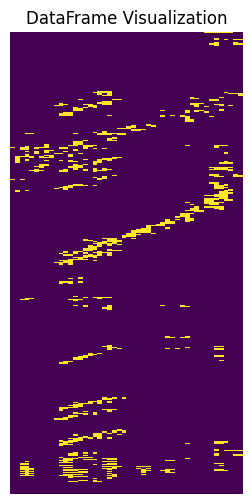

In [20]:
#BINARIZATION
df_binarized = (df_norm > np.percentile(df_norm, 95)).astype(int)
print("binarized after gauss")
plot_dataframe_as_image(df_binarized.values,3,6)

In [21]:
# # Perform morphological closing to fill holes in the binary image
# kernel = np.ones((3, 3), np.uint8)  # Define a kernel for the morphological operation
# closed_image = cv2.morphologyEx(df_binarized.values.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=1)

# print("Connected lines after closing")
# plot_dataframe_as_image(closed_image, 3, 6)

In [22]:
# #OPENING FOR NOISE REDUCTION
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# opening = cv2.morphologyEx(closed_image.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=1)
# print("opening")
# plot_dataframe_as_image(pd.DataFrame(opening), 3, 6)

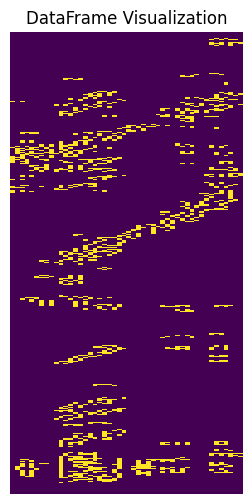

In [23]:
edges = cv2.Canny(df2.values.astype(np.uint8), 50, 100)

if edges is not None and np.any(edges):
    edges_df = pd.DataFrame(edges)
    plot_dataframe_as_image(edges_df, 3, 6)
else:
    print("No edges were detected.")

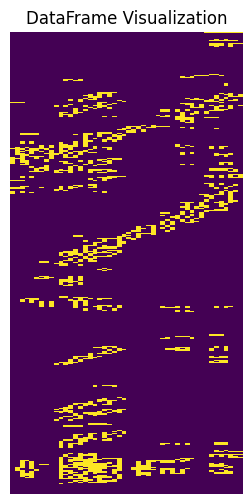

In [24]:
edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
plot_dataframe_as_image(edges_closed, 3, 6)

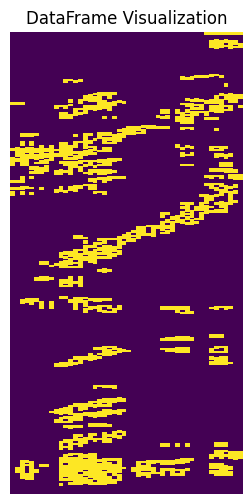

In [25]:
edges_dilated = cv2.dilate(edges_closed, kernel, iterations=4)
plot_dataframe_as_image(edges_dilated, 3, 6)

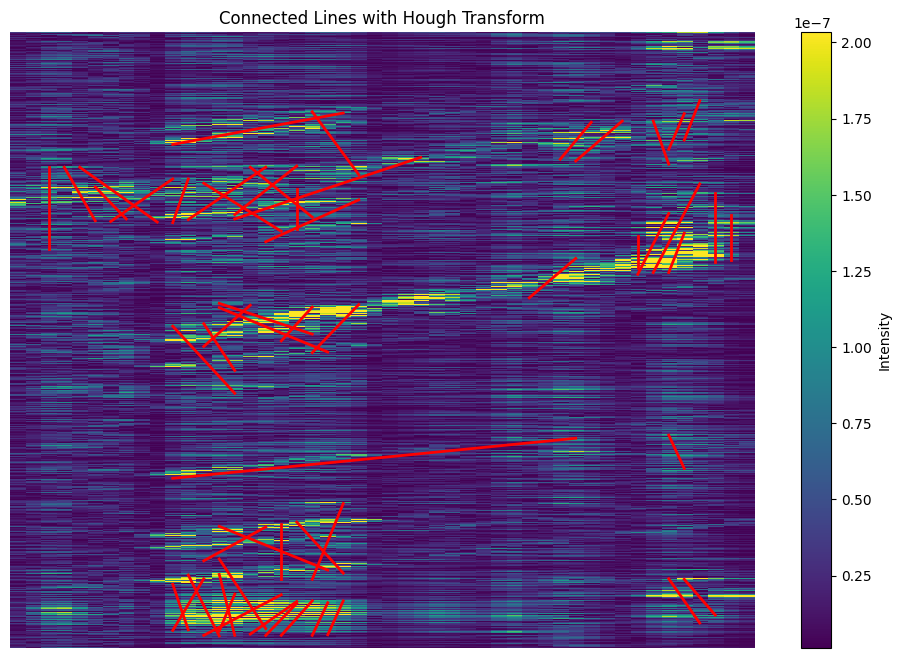

In [26]:
lines = cv2.HoughLinesP(edges_dilated, rho=1, theta=np.pi / 180, threshold=10, minLineLength=50, maxLineGap=20)
plot_lines_on_dataframe(df, lines, title="Connected Lines with Hough Transform")

In [27]:
# def merge_lines(lines, min_distance=20, max_angle_diff=5):
#     """
#     Merges lines that are close together and have similar angles,
#     then represents each group by a bounding line using the
#     top-left and bottom-right coordinates.

#     Parameters:
#     lines (list): List of lines detected by HoughLinesP (x1, y1, x2, y2).
#     min_distance (float): Minimum distance to consider two lines as part of the same group.
#     max_angle_diff (float): Maximum angle difference (in degrees) to group lines.

#     Returns:
#     list: A list of merged lines represented as [[[x1, y1, x2, y2]], ...].
#     """
#     if lines is None or len(lines) == 0:
#         return []

#     merged_groups = []

#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         # Ensure x1, y1 is always the "leftmost" point
#         if x1 > x2:
#             x1, x2 = x2, x1
#             y1, y2 = y2, y1

#         angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
#         added = False

#         for group in merged_groups:
#             gx1, gy1, gx2, gy2, gangle = group
#             # Calculate the midpoints of the line and group
#             mid_x1, mid_y1 = (gx1 + gx2) / 2, (gy1 + gy2) / 2
#             mid_x2, mid_y2 = (x1 + x2) / 2, (y1 + y2) / 2
#             mdistance = np.sqrt((mid_x1 - mid_x2) ** 2 + (mid_y1 - mid_y2) ** 2)

#             if mdistance < min_distance and abs(gangle - angle) < max_angle_diff:
#                 # Update group boundaries to include this line
#                 group[0] = min(gx1, x1)
#                 group[1] = min(gy1, y1)
#                 group[2] = max(gx2, x2)
#                 group[3] = max(gy2, y2)
#                 group[4] = (gangle + angle) / 2
#                 added = True
#                 break

#         if not added:
#             merged_groups.append([x1, y1, x2, y2, angle])

#     # Convert groups to properly oriented bounding lines
#     merged_lines = [[[group[0], group[1], group[2], group[3]]] for group in merged_groups]

#     return merged_lines




def merge_lines(lines, min_distance=20, max_angle_diff=5):
    """
    Groups lines that are close together and have similar angles, then selects
    the longest, most central line in each group to represent the moving object.

    Parameters:
    lines (list): List of lines detected by HoughLinesP (x1, y1, x2, y2).
    min_distance (float): Minimum distance to consider two lines as part of the same group.
    max_angle_diff (float): Maximum angle difference (in degrees) to group lines.

    Returns:
    list: A list of selected lines represented as [[[x1, y1, x2, y2]], ...].
    """
    if lines is None or len(lines) == 0:
        return []

    merged_groups = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Calculate line length
        midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)  # Calculate midpoint
        added = False

        for group in merged_groups:
            gx1, gy1, gx2, gy2, gangle, glines = group
            group_midpoint = ((gx1 + gx2) / 2, (gy1 + gy2) / 2)
            group_distance = np.sqrt(
                (midpoint[0] - group_midpoint[0]) ** 2
                + (midpoint[1] - group_midpoint[1]) ** 2
            )

            if group_distance < min_distance and abs(gangle - angle) < max_angle_diff:
                # Add the line to this group
                group[0] = min(gx1, x1, x2)  # Update group boundaries
                group[1] = min(gy1, y1, y2)
                group[2] = max(gx2, x1, x2)
                group[3] = max(gy2, y1, y2)
                group[4] = (gangle + angle) / 2  # Average the angles
                group[5].append((x1, y1, x2, y2, length, midpoint))  # Add line details
                added = True
                break

        if not added:
            # Create a new group for this line
            merged_groups.append([x1, y1, x2, y2, angle, [(x1, y1, x2, y2, length, midpoint)]])

    # Select the longest, most central line from each group
    selected_lines = []
    for group in merged_groups:
        group_lines = group[5]  # All lines in the group
        group_midpoint = (
            (group[0] + group[2]) / 2,
            (group[1] + group[3]) / 2,
        )  # Group's overall midpoint

        # Find the line that is the longest and most central
        def line_score(line):
            _, _, _, _, length, midpoint = line
            centrality = -np.sqrt(
                (midpoint[0] - group_midpoint[0]) ** 2
                + (midpoint[1] - group_midpoint[1]) ** 2
            )
            return length, centrality

        best_line = max(group_lines, key=line_score)
        selected_lines.append([[best_line[0], best_line[1], best_line[2], best_line[3]]])

    return selected_lines


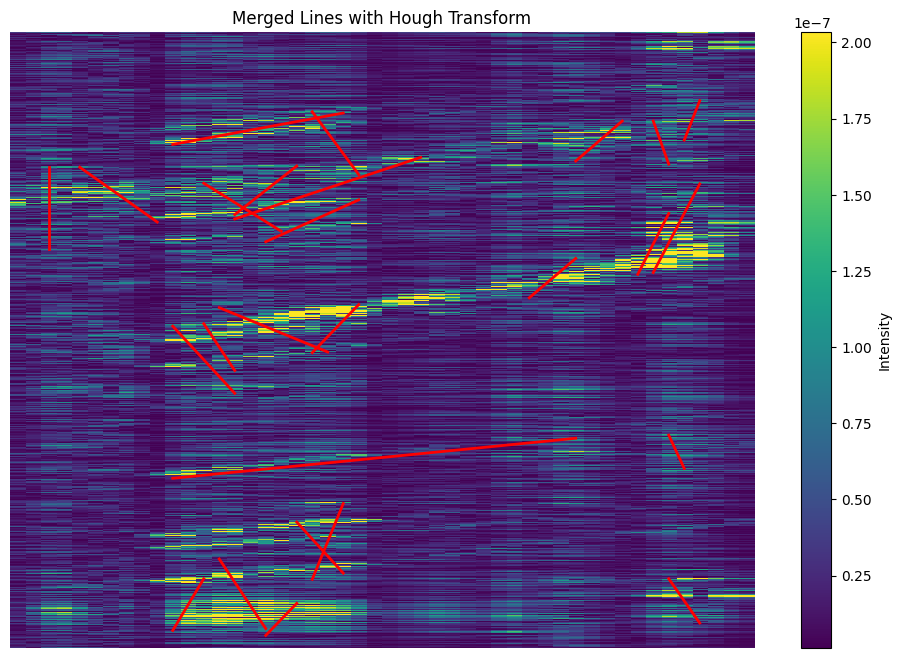

In [28]:
merged_lines = merge_lines(lines)

# Plot merged lines
plot_lines_on_dataframe(df, merged_lines, title="Merged Lines with Hough Transform")

In [29]:
df.shape

(1000, 48)

In [30]:
#FAJNY KOD DO USTAWIENIA DX I DT

# Original values
original_dx = 5.106500953873407
original_dt = 0.0016
original_shape = (75000, 52)  # (rows, columns)

# New dataframe shape
new_shape = (1000, 48)  # (rows, columns)

# Calculate new dx and dt
new_dt = original_dt * (original_shape[0] / new_shape[0])
new_dx = original_dx * (original_shape[1] / new_shape[1])

print(f"New dx: {new_dx:.3f} meters/column")
print(f"New dt: {new_dt:.3f} seconds/row")


New dx: 5.532 meters/column
New dt: 0.120 seconds/row


In [31]:
def calculate_velocities(lines, dx, dt):
    """
    Calculate velocities for each line based on its slope.

    Parameters:
        lines (list): List of merged lines in the format [[[x1, y1, x2, y2]], ...].
        dx (float): Spatial resolution (distance per column).
        dt (float): Temporal resolution (time per row).

    Returns:
        list: A list of velocities corresponding to each line.
    """
    velocities = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 != x1:  # Avoid division by zero
            slope = (y2 - y1) / (x2 - x1)  # Slope in pixels
            velocity = abs(dx / (slope * dt)) * 3.6  # Convert to km/h
            velocities.append(velocity)
        else:
            velocities.append(None)  # Vertical line: undefined velocity
    return velocities

velocities = calculate_velocities(merged_lines, new_dx, new_dt)
print(velocities)




[8.403102835487886, 2.6985574146485485, 2.3708754428697962, 7.659751430810109, 3.4575266875184525, 6.383126192341759, 19.915353720106285, 4.3674021316022555, 9.323667471959872, 7.77943504691652, 4.406051707988117, 3.9514590714496607, 4.610035583357937, 3.352753151533045, 6.090322238564614, 16.13512454175278, 5.998600518104303, 35.795570411955744, 66.3845124003543, None, 3.0733570555719583, 4.881214147084875, 14.643642441254624, 2.59314501563884, 10.638543653902932, 6.383126192341759]


In [32]:
def plot_lines_with_velocities(df, lines, velocities, title="Lines with Velocities"):
    """
    Plots lines on the DataFrame with velocity annotations.

    Parameters:
        df (pd.DataFrame): The DataFrame to visualize.
        lines (list): List of lines in the format [[[x1, y1, x2, y2]], ...].
        velocities (list): List of velocities corresponding to each line.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 8))
    plt.imshow(df.values, cmap="viridis", aspect="auto", interpolation="none")
    plt.colorbar(label="Intensity")
    
    if lines is not None:
        for i, line in enumerate(lines):
            x1, y1, x2, y2 = line[0]
            plt.plot([x1, x2], [y1, y2], color='red', linewidth=2)

            # Annotate velocity
            if velocities[i] is not None:
                mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                plt.text(mid_x, mid_y, f"{velocities[i]:.2f} km/h", color="yellow", fontsize=10, ha="center", va="center")

    plt.title(title)
    plt.xlabel("Columns (Space)")
    plt.ylabel("Rows (Time)")
    plt.show()


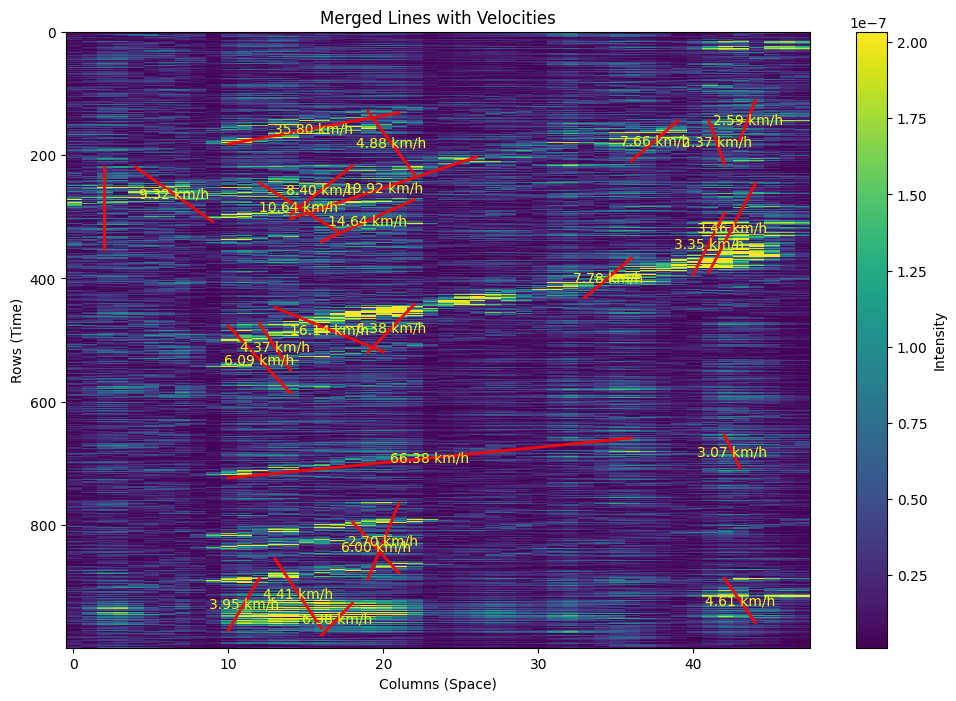

In [33]:
plot_lines_with_velocities(df, merged_lines, velocities, title="Merged Lines with Velocities")

erosion


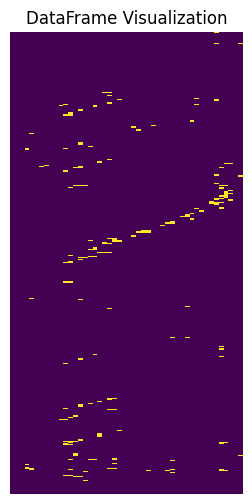

In [34]:
#EROSION, 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
eroded_image = cv2.erode(df_binarized.values.astype(np.uint8), kernel, iterations=1)
df_eroded = pd.DataFrame(eroded_image, columns=df.columns)
print("erosion")
plot_dataframe_as_image(df_eroded,3,6)

dilation


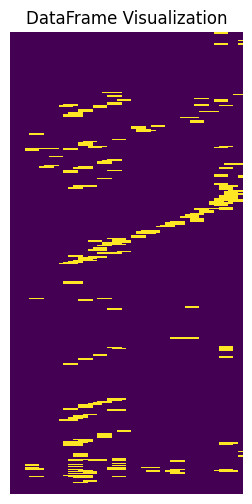

In [35]:
#DILATION
kernel_diagonal = np.ones((2,2), dtype=np.uint8)
# for i in range(20):
#     kernel_diagonal[i, min(i, 4)] = 1
kernel_flip =  np.flip(kernel_diagonal,axis=1 )
# print(kernel_flip)
img_bin_dil = cv2.dilate(df_eroded.values.astype(np.uint8), kernel_flip, iterations=2)   #i have like 20 pixels gaps on vertical. 
df_dilated = pd.DataFrame(img_bin_dil, columns=df.columns)
print("dilation")
plot_dataframe_as_image(df_dilated,3,6)

smooth edges


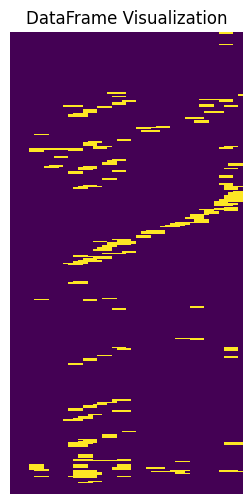

In [36]:
# CLOSE VERTICAL
vertical_kernel = np.ones((2, 2), dtype=np.uint8)
closed_image = cv2.morphologyEx(df_dilated.values.astype(np.uint8), cv2.MORPH_CLOSE, vertical_kernel)
print("smooth edges")
df_smooth = pd.DataFrame(closed_image, columns = df.columns)
plot_dataframe_as_image(df_smooth,3,6)